# What is nonograms?

Nonograms, also known as Hanjie, Paint by Numbers, Picross, Griddlers, and Pic-a-Pix are picture logic puzzles in which cells in a grid must be colored or left blank according to numbers at the edges of the grid to reveal a hidden picture. In this puzzle, the numbers are a form of discrete tomography that measures how many unbroken lines of filled-in squares there are in any given row or column. For example, a clue of "4 8 3" would mean there are sets of four, eight, and three filled squares, in that order, with at least one blank square between successive sets.

These puzzles are often black and white—describing a binary image—but they can also be colored. If colored, the number clues are also colored to indicate the color of the squares. Two differently colored numbers may or may not have a space in between them. For example, a black four followed by a red two could mean four black boxes, some empty spaces, and two red boxes, or it could simply mean four black boxes followed immediately by two red ones. Nonograms have no theoretical limits on size, and are not restricted to square layouts.

Nonograms were named after Non Ishida, one of the two inventors of the puzzle.

- Example image

![example.png](nonogram_example.png)

Solving nonograms puzzles is an NP-complete problem. This means that there is no polynomial time algorithm that solves all nonograms puzzles unless P = NP.

\- Source: Wikipedia


#### Classical computer solves the nonograms in $O(N)$ time for N possible patterns, But if we use quantum computers, we can this in $O(\sqrt{N})$ time. So we can expect exponential speedup compare to classical computer, for this NP-complete problem.

# Qiskit Installation and library Import

In [ ]:
%pip install qiskit
%pip install qiskit_aer
%pip install pylatexenc

In [109]:
# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit.visualization import *

# Importing Numpy
import numpy as np

# Quantum simulator
from qiskit_aer import Aer
from qiskit.visualization import plot_histogram

# Operator and Gate
from qiskit.circuit.library import MCXGate

# Itertools
from itertools import combinations

# matplotlib
from matplotlib import pyplot as plt

# 1. Nonograms row/column check algorithm

Let's encode the black square to 1 and the white squre to 0. Then we can encode any nonograms pattern to binary image.

- Example <br><br>
![example_2.png](nonogram_example_2.png)
<br> 0 0 0 0 0 0 0 0 <br> 0 1 1 1 1 0 0 0 <br> 0 1 1 1 1 1 1 0 <br> 0 1 1 0 0 1 1 0 <br> 0 1 1 0 0 1 1 0 <br> 0 1 1 1 1 1 1 0 <br> 0 1 1 1 1 0 0 0 <br> 0 1 1 0 0 0 0 0 <br> 0 1 1 0 0 0 0 0 <br> 0 1 1 0 0 0 0 0 <br> 0 0 0 0 0 0 0 0

<br>
→ 0000000001111000011111100110011001100110011111100111100001100000011000000110000000000000
<br>

### ■ Example - 3 bits, condition: (1)

Every 3 bitstrings for satisfying the condition are (100, 010, 001).
 
We can check all these bitstrings by following quantum algorithm.

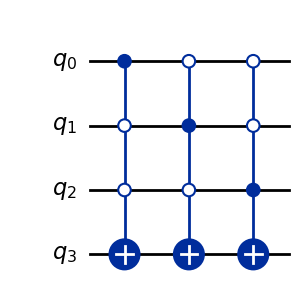

In [97]:
qr_test = QuantumRegister(4, name='q')
qc = QuantumCircuit(qr_test)
qc.append(MCXGate(3, ctrl_state="100"), [2, 1, 0, 3])
qc.append(MCXGate(3, ctrl_state="010"), [2, 1, 0, 3])
qc.append(MCXGate(3, ctrl_state="001"), [2, 1, 0, 3])

qc.draw(output="mpl", reverse_bits=False)

If we check every row/colunm bitstrings for nonograms, we need (n+m) ancilla qubits for (nxm) nonograms.

# 2. Oracle for nonograms

Just sum up every results of ancilla qubits and return them to initial state, we can complete whole oracle algorithm.

### ■ Example - 3 bits + 3 bits, condition: (1) + (1, 1)

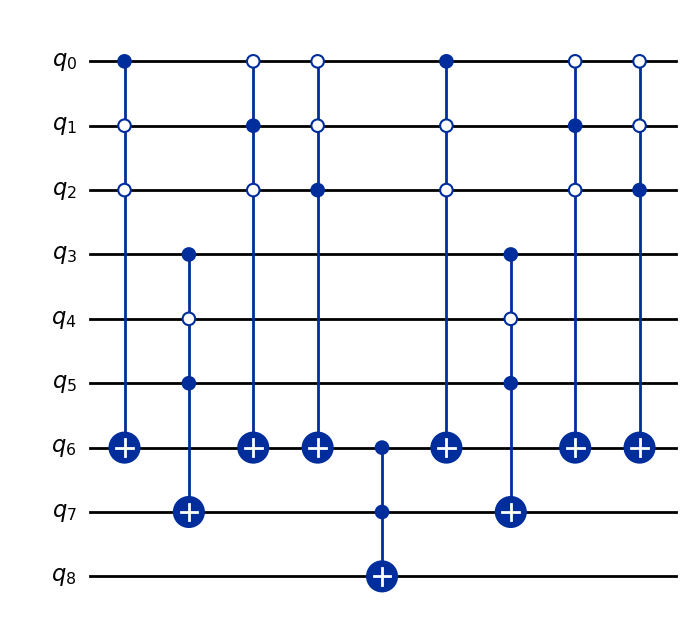

In [100]:
qr_test = QuantumRegister(9, name='q')
qc = QuantumCircuit(qr_test)
qc.append(MCXGate(3, ctrl_state="100"), [2, 1, 0, 6])
qc.append(MCXGate(3, ctrl_state="010"), [2, 1, 0, 6])
qc.append(MCXGate(3, ctrl_state="001"), [2, 1, 0, 6])
qc.append(MCXGate(3, ctrl_state="101"), [3, 4, 5, 7])
qc.append(MCXGate(2, ctrl_state="11"), [6, 7, 8])
qc.append(MCXGate(3, ctrl_state="100"), [2, 1, 0, 6])
qc.append(MCXGate(3, ctrl_state="010"), [2, 1, 0, 6])
qc.append(MCXGate(3, ctrl_state="001"), [2, 1, 0, 6])
qc.append(MCXGate(3, ctrl_state="101"), [3, 4, 5, 7])
qc.draw(output="mpl", reverse_bits=False)

#### The figure above becomes oracle algorithm. q1~q5 are data registers, q6~q7 are ancilla registers, q8 is y input register(phase kickback register). This alogorithm inverts q8 only for states that satisfies condition, and also returns the ancilla qubits to initial state.

# 3. Diffuser gate

#### Diffuser gates do inversion around mean to phase-kickbacked input state. Such procedure amplifies probability of desired states.

Diffuser gate operator
$$
D = 
H(2\vert 0\rangle\langle 0 \vert - I)H = 2\vert \psi\rangle\langle \psi \vert - I
$$

### ■ Example - diffuser gate for 4 qubits

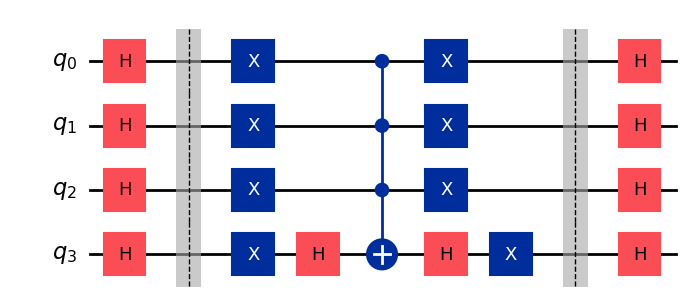

In [107]:
qc = QuantumCircuit(4)
# Apply transformation |s> -> |00..0> (H-gates)
for qubit in range(4): qc.h(qubit)
qc.barrier(range(4))
# Apply transformation |00..0> -> |11..1> (X-gates)
for qubit in range(4): qc.x(qubit)
# Do multi-controlled-Z gate
qc.h(4-1)
qc.mcx(list(range(4-1)), 4-1)  # multi-controlled-toffoli (CCCX)
qc.h(4-1)
# Apply transformation |11..1> -> |00..0>
for qubit in range(4): qc.x(qubit)
qc.barrier(range(4))
# Apply transformation |00..0> -> |s>
for qubit in range(4): qc.h(qubit)
# We will return the diffuser as a gate

qc.draw(output="mpl", reverse_bits=False)

#### The quantum circuit between barriers inverts whole state only for |0000> state.

# 4. Grover algorithm for solving nonograms

Grover gate ($G$) : $ G = D∙O $  (D: Diffuser gate, O: Oracle)

For n data qubits, appropriate grover iteration number is approximately $\sqrt{N}$   ($N=2^n$)

So after $G^{\sqrt{N}}$ iterations, the data state converges to the answer state of nonograms.

Let's generalize the algorithm to any (nxm) nonograms.

In [132]:
# Make appropriate regs for given nonograms size
def make_data_regs_list(num_rows, num_cols):
    data_regs_list = []

    # Add row regs
    for i in range(0, num_rows):
        data_regs_row = [k for k in range(num_cols*i, num_cols*(i+1))]
        data_regs_row.reverse()
        data_regs_list.append(data_regs_row)

    # Add col regs
    for i in range(0, num_cols):
        data_regs_row = [i+k*num_cols for k in range(0, num_rows)]
        data_regs_row.reverse()
        data_regs_list.append(data_regs_row)

    return data_regs_list

# Get ctrl states for condition
def get_ctrl_states(bit_len, cond):
    ctrl_states = []
    n = len(cond)+1
    r = bit_len-sum(cond)-(len(cond)-1)
    
    # Calculate nHr (multiset coefficient) and make ctrl_string
    for combi in combinations(list(range(n+r-1)), n-1):
        num_choosed = [combi[0]]+[combi[i+1]-combi[i]-1 for i in range(len(combi)-1)]
        ctrl_string = ""
        for i in range(len(num_choosed)):
            ctrl_string += "0"*num_choosed[i]
            ctrl_string += "1"*cond[i]
            if i != len(num_choosed)-1: ctrl_string += "0"
        ctrl_string += "0"*(bit_len-len(ctrl_string))

        ctrl_states.append(ctrl_string)

    return ctrl_states

# Apply condtion to row/col
def apply_condition(qc, cond, data_regs, target_ancilla):
    bit_len = len(data_regs)
    label = data_regs.copy()
    label.append(target_ancilla)
    ctrl_state_lst = get_ctrl_states(bit_len, cond)

    # Add MCXGate
    for ctrl_state in ctrl_state_lst:
        qc.append(MCXGate(bit_len, ctrl_state=ctrl_state), label)

    return qc

# Sum up all ancillas
def sumup_ancilla(qc, num_data, num_ancilla):
    ctrl_state = ""
    label = [num_data+i for i in range(num_ancilla+1)]
    for i in range(num_ancilla):
        ctrl_state += "1"
    qc.append(MCXGate(num_ancilla, ctrl_state=ctrl_state), label)

# Define oracle gate for given conditions
def get_oracle(num_rows, num_cols, conditions):
    
    # Setup qunatum circuit
    num_data = num_rows*num_cols
    num_ancilla = num_rows+num_cols
    qc = QuantumCircuit(num_data+num_ancilla+1)

    # Make oracle operation
    data_regs_list = make_data_regs_list(num_rows, num_cols)

    for i, data_regs in enumerate(data_regs_list):
        target_ancilla = i+num_rows*num_cols
        apply_condition(qc, conditions[i], data_regs, target_ancilla)

    sumup_ancilla(qc, num_data, num_ancilla)

    for i, data_regs in enumerate(data_regs_list):
        target_ancilla = i+num_rows*num_cols
        apply_condition(qc, conditions[i], data_regs, target_ancilla)

    oracle = qc.to_gate()
    oracle.name ='Oracle'

    return oracle

# Get diffuser gate
def get_diffuser(nqubits):
    qc = QuantumCircuit(nqubits)
    # Apply transformation |s> -> |00..0> (H-gates)
    for qubit in range(nqubits):
        qc.h(qubit)
    # Apply transformation |00..0> -> |11..1> (X-gates)
    for qubit in range(nqubits):
        qc.x(qubit)
    # Do multi-controlled-Z gate
    qc.h(nqubits-1)
    qc.mcx(list(range(nqubits-1)), nqubits-1)  # multi-controlled-toffoli
    qc.h(nqubits-1)
    # Apply transformation |11..1> -> |00..0>
    for qubit in range(nqubits):
        qc.x(qubit)
    # Apply transformation |00..0> -> |s>
    for qubit in range(nqubits):
        qc.h(qubit)
    # We will return the diffuser as a gate
    
    U_s = qc.to_gate()
    U_s.name = "U$_s$"

    return U_s


# Nonograms definition
def create_nonograms_grover_circuit(num_rows, num_cols, conditions):
    
    # Setup qunatum circuit
    num_data = num_rows*num_cols
    num_ancilla = num_rows+num_cols
    num_qubits = num_data+num_ancilla+1
    num_grover_iteration = int(np.sqrt(np.power(2,num_rows*num_cols)))

    # Get oracle and diffuser gates
    oracle = get_oracle(num_rows, num_cols, conditions)
    diffuser = get_diffuser(num_data)

    # Quantum circuit setup
    qr_data = QuantumRegister(num_data, name='x')
    qr_ancilla = QuantumRegister(num_ancilla, name='a')
    qr_y = QuantumRegister(1, name='y')
    cr = ClassicalRegister(num_data)
    qc = QuantumCircuit(qr_data, qr_ancilla, qr_y, cr)

    # Initialize state
    qc.h(range(num_data))
    qc.h(num_qubits-1)
    qc.z(num_qubits-1)

    # Grover iteration
    for _ in range(num_grover_iteration):
        qc.append(oracle, range(num_qubits))
        qc.append(diffuser, range(num_data))

    # measure
    qc.barrier(range(num_qubits))
    qc.measure(range(num_data), reversed(range(num_data)))

    return qc

### ■ Example 1 - 3x3 nonograms

![example_3x3_1.png](3x3_nonograms_1.png)

Let's encode this nonogram to quantum circuit.

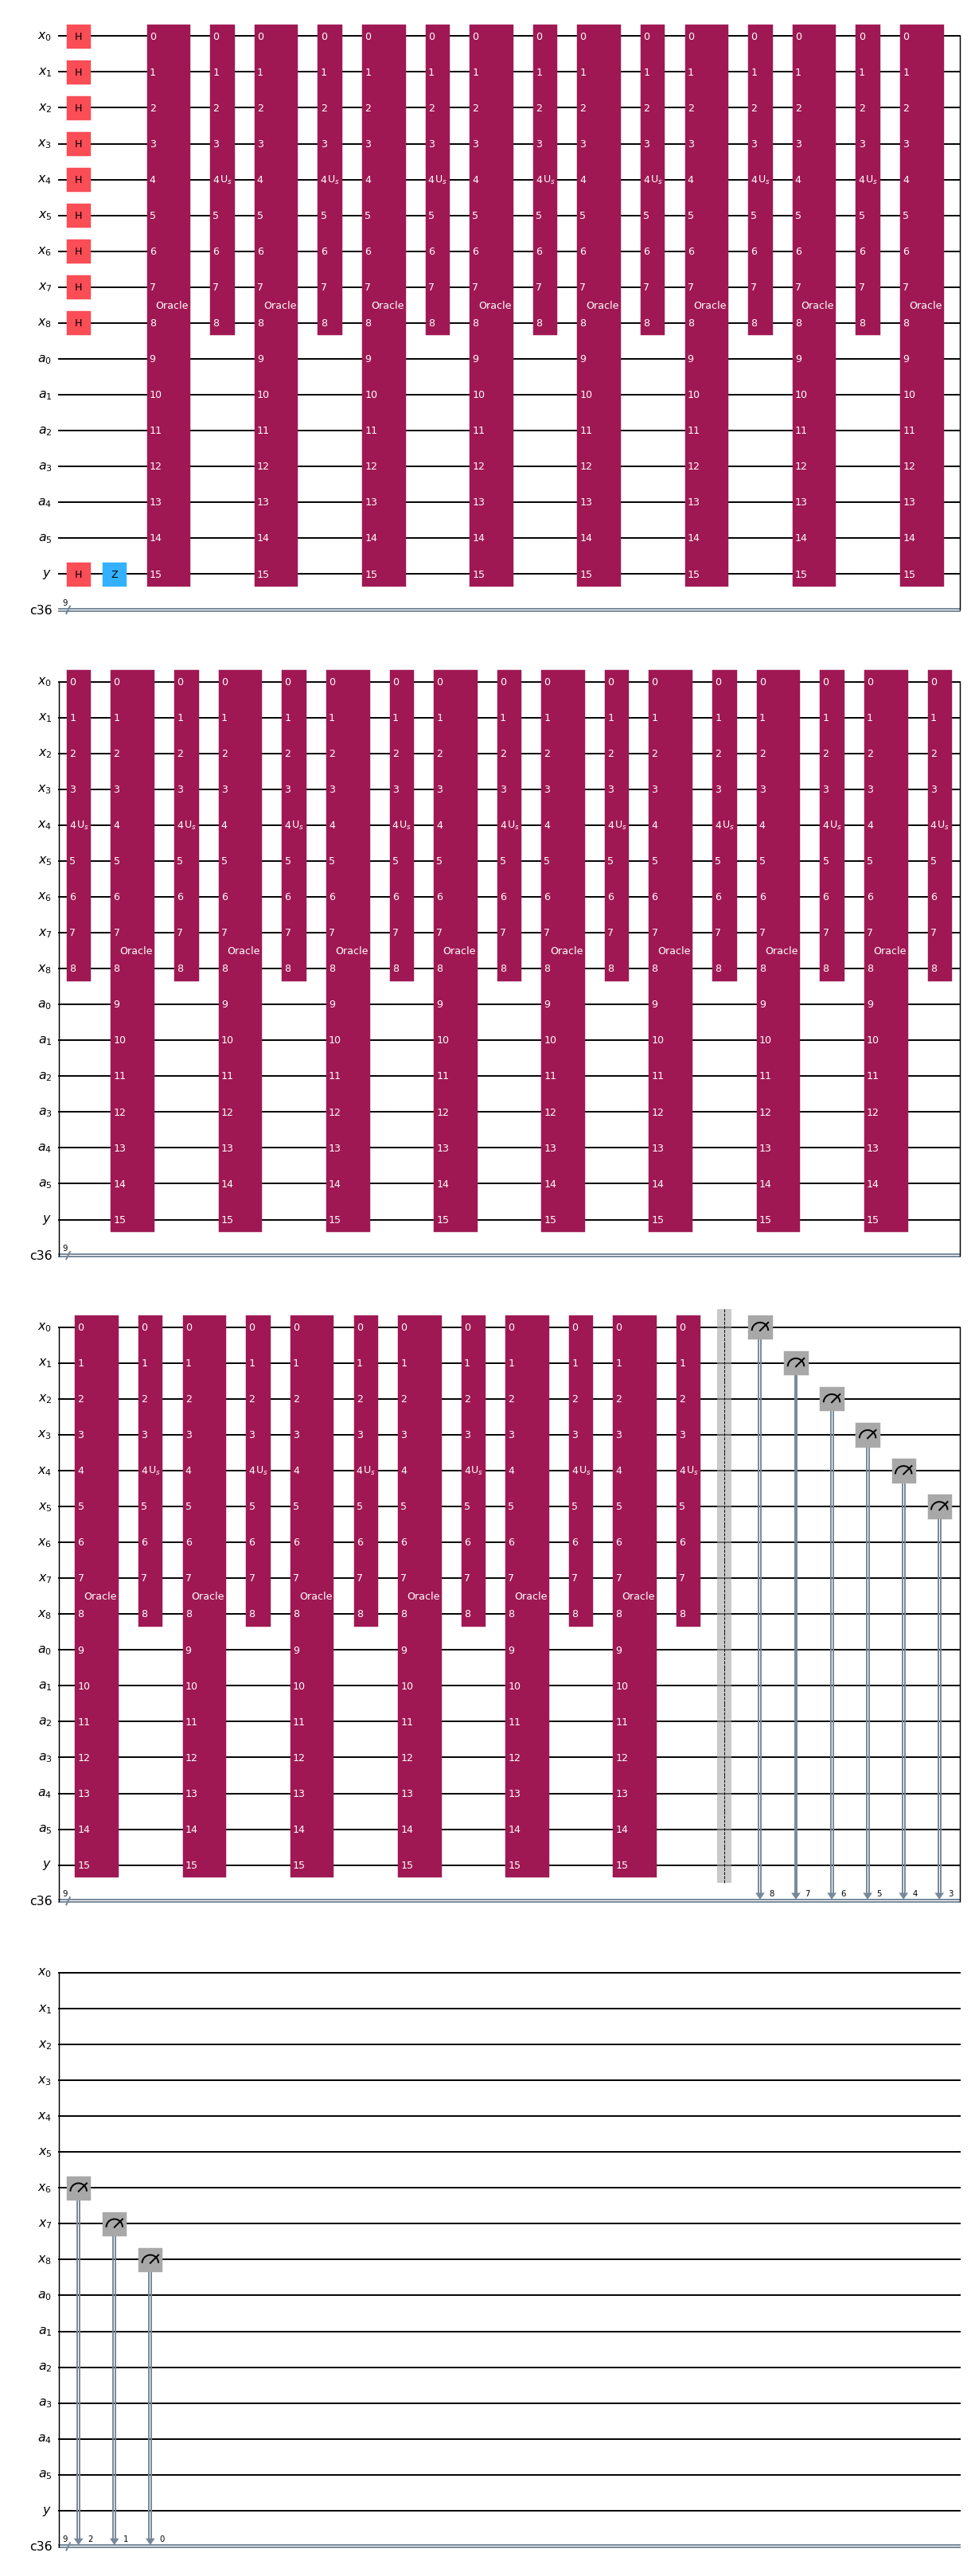

In [134]:
num_rows, num_cols = 3, 3
conditions = [[1, 1], [1], [1, 1], [1, 1], [1], [1, 1]]
qc = create_nonograms_grover_circuit(num_rows, num_cols, conditions)
qc.draw(output="mpl", reverse_bits=False, scale=0.7)

In [135]:
n_shots = 100000
backend_aer = Aer.get_backend('qasm_simulator')
transpiled_qc = transpile(qc, backend_aer)
result = backend_aer.run(transpiled_qc,shots=n_shots).result().get_counts()
print(result)

{'100111100': 30, '000011011': 23, '101010101': 83626, '010101010': 31, '101000101': 32, '110000001': 32, '101101100': 34, '011110100': 30, '001101101': 38, '101101101': 33, '110000110': 35, '111000111': 34, '001100001': 30, '100100010': 28, '101101111': 35, '110000100': 31, '100001100': 29, '100010000': 39, '001110001': 25, '001001101': 39, '011001100': 28, '011100001': 43, '100000101': 32, '001000010': 32, '100011111': 27, '010100010': 37, '101001111': 33, '110100011': 41, '001000111': 38, '100000000': 31, '100011100': 32, '001111011': 22, '011001111': 29, '011100100': 33, '101001101': 44, '000001001': 32, '010100000': 30, '000111011': 26, '000100101': 38, '100001101': 27, '001001100': 36, '001110110': 26, '100010111': 29, '000001110': 31, '101001000': 30, '011010011': 35, '011011110': 45, '111010010': 37, '010110111': 29, '101111100': 41, '001011011': 36, '101011001': 42, '010101001': 32, '000000000': 34, '110100010': 36, '111110101': 24, '101111011': 33, '001011100': 27, '010110110

C:\Users\신용식\AppData\Local\Temp\ipykernel_26020\2753274463.py:10: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  plt.xticks([])


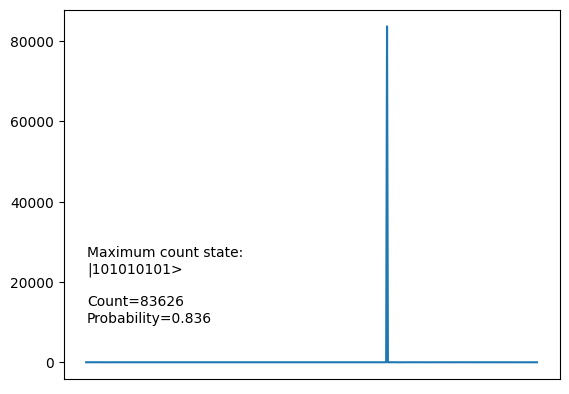

In [144]:
def plot_result(result:dict):
    lists = sorted(result.items())
    x, y = zip(*lists)
    ymax = max(y)
    xpos = y.index(ymax)
    xmax = x[xpos]
    plt.plot(x, y)
    text= "Maximum count state:\n|"+xmax+">\n\nCount={}\nProbability={}".format(ymax, round(ymax/100000, 3))
    plt.annotate(text, xy=(xmax, ymax), xytext=(1,10000))
    plt.xticks([])

plot_result(result)

#### → The result same to the answer of nonograms.

### ■ Example 2 - Other 3x3 nonograms

![example_3x3_2.png](3x3_nonograms_2.png)
![example_3x3_3.png](3x3_nonograms_3.png)

In [148]:
qc1 = create_nonograms_grover_circuit(3, 3, [[1], [3], [1], [1], [3], [1]])
qc2 = create_nonograms_grover_circuit(3, 3, [[1], [1,1], [1], [1], [1,1], [1]])

transpiled_qc1 = transpile(qc1, backend_aer)
transpiled_qc2 = transpile(qc2, backend_aer)
result_1 = backend_aer.run(transpiled_qc1,shots=n_shots).result().get_counts()
result_2 = backend_aer.run(transpiled_qc2,shots=n_shots).result().get_counts()

C:\Users\신용식\AppData\Local\Temp\ipykernel_26020\2753274463.py:10: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  plt.xticks([])


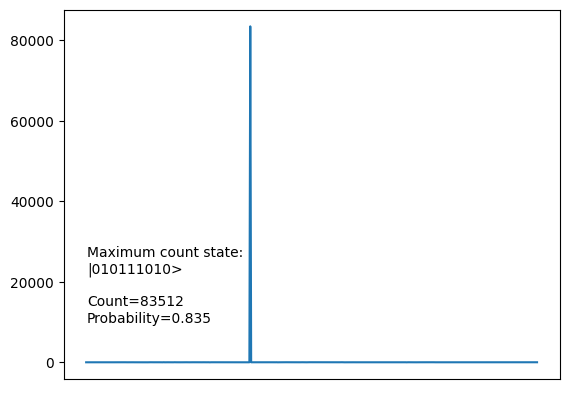

In [149]:
plot_result(result_1)

C:\Users\신용식\AppData\Local\Temp\ipykernel_26020\2753274463.py:10: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  plt.xticks([])


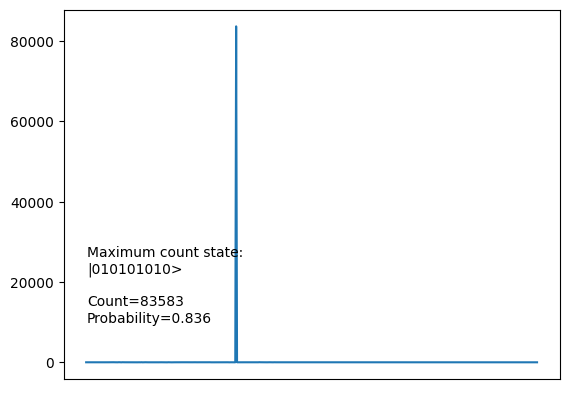

In [150]:
plot_result(result_2)

#### → The results same to the answers of nonograms.

### ■ Example 3 - 3x4 nonograms

![example_3x3_2.png](3x4_nonograms.png)

In [153]:
conditions = [[2, 1], [1], [2], [1], [3], [1], [1]]
qc = create_nonograms_grover_circuit(3, 4, conditions)
transpiled_qc = transpile(qc, backend_aer)
result = backend_aer.run(transpiled_qc, shots=n_shots).result().get_counts()

C:\Users\신용식\AppData\Local\Temp\ipykernel_26020\2753274463.py:10: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  plt.xticks([])


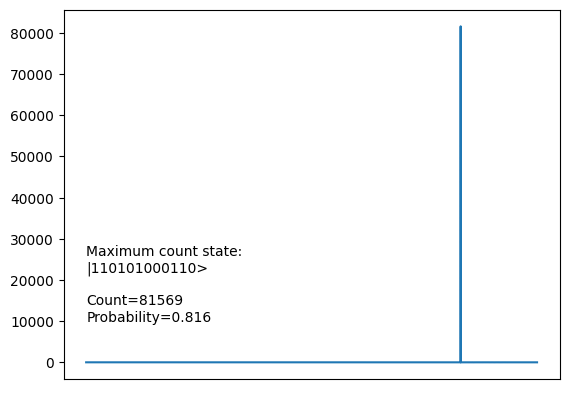

In [154]:
plot_result(result)

#### → The results same to the answers of nonograms.

### ■ Example 4 - 4x4 nonograms

![example_3x3_2.png](4x4_nonograms.png)

In [155]:
conditions = [[3], [2], [4], [1, 1], [2], [4], [1, 1], [1, 2]]

qc = create_nonograms_grover_circuit(4, 4, conditions)

In [156]:
transpiled_qc = transpile(qc, backend_aer)
result = backend_aer.run(transpiled_qc,shots=n_shots).result().get_counts()
print(result)

{'0100111001100010': 1, '0111100110110011': 1, '1100101111011011': 1, '0100001100101000': 3, '0111111000010110': 1, '1101011110110100': 1, '1000101111111110': 1, '0110011100110101': 1, '1111010000101010': 1, '1111111100111101': 1, '1000111100011000': 2, '1100011011100101': 1, '0101110001100011': 1, '0000110101110010': 1, '0000011001001001': 1, '1010011101000001': 1, '1000110111000000': 1, '0111011011010010': 2, '0011000100001110': 2, '1011111100000101': 2, '1100111000010010': 2, '0101001101101100': 1, '0110000000100101': 1, '1110110110110100': 1, '0111110011110101': 82476, '0111000110111011': 1, '1110001000111000': 1, '1101010110010110': 1, '0100101011011010': 1, '1110100010000111': 1, '0111010001100111': 1, '1000011101100101': 2, '1111010101100001': 1, '0101011110010011': 1, '0100111101000110': 2, '0000110011100010': 1, '0111110011010110': 1, '1011011010001101': 1, '1001111001011110': 1, '0110111010101000': 1, '1101111100110011': 2, '1111001000111010': 1, '1011000010110000': 1, '10101

C:\Users\신용식\AppData\Local\Temp\ipykernel_26020\2128546449.py:9: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  plt.xticks([])


([], [])

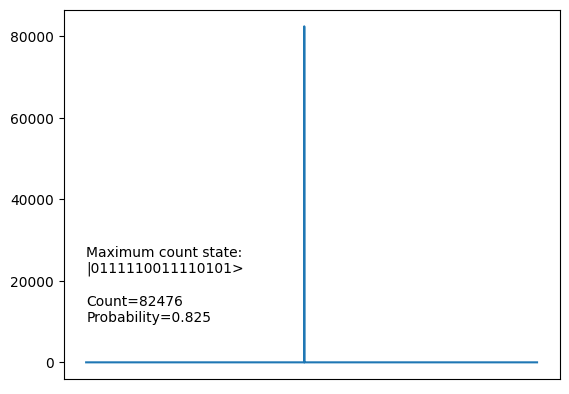

In [157]:
lists = sorted(result.items())
x, y = zip(*lists)
ymax = max(y)
xpos = y.index(ymax)
xmax = x[xpos]
plt.plot(x, y)
text= "Maximum count state:\n|"+xmax+">\n\nCount={}\nProbability={}".format(ymax, round(ymax/100000, 3))
plt.annotate(text, xy=(xmax, ymax), xytext=(1,10000))
plt.xticks([])